In [136]:
from pathlib import Path

import pandas as pd # also openpyxl for xlsx files
import numpy as np
import scipy.signal as ss
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm, trange

# from utils import read_trc, read_mot
# import ocfeats

# gdrive = Path('/Volumes/GoogleDrive-112026393729621442608')
gdrive = Path('/Users/psr/Library/CloudStorage/GoogleDrive-paru@stanford.edu')
datadir = gdrive / 'My Drive/NMBL Lab/OpenCap for NMD biomarkers/data'
dataset = '2023-05_dhd'


In [137]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466"]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72



In [138]:
df_session = pd.read_excel(datadir / dataset / 'session_info.xlsx', )
df_trial = pd.read_excel(datadir / dataset / 'trial_info.xlsx')
df_part = pd.read_excel(datadir / dataset / 'participant_info.xlsx')

feats_path = Path('./feats.pkl')
df_feat = pd.read_pickle(feats_path)

survey_fpath = gdrive / datadir / dataset / 'redcap_data/DHD Data Export_6June2023.csv'
df_survey = pd.read_csv(survey_fpath, usecols=['open_id', 'activ_total'] + [f'activ_{i+1}' for i in range(22)])
df_survey['pid'] = df_survey.open_id.apply(lambda x: x.lower() if isinstance(x, str) else x)
df_survey.drop(columns='open_id', inplace=True)
# df_survey = df_survey[['pid'] + list(df_survey.columns[:-1])]


In [139]:
oc_feats = list(df_feat.columns[1:])
tft_feats = [f for f in df_part.columns if f.startswith('time_')]
tfts_and_brooke = tft_feats + ['brooke']
pro_feats = list(df_survey.columns[1:-1])

df_all = df_feat.merge(df_part, on='pid', how='outer')
df_all = df_all.merge(df_survey, on='pid', how='outer')


In [140]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score

def three_class_lda_cv(data, feats, label, show=True):
    df_train = data[['pid']+[label]+feats].dropna()

    X = df_train.loc[:,feats].values
    y = df_train.loc[:,label].values

    X -= X.mean(axis=0)
    X /= X.std(axis=0)

    lda = LinearDiscriminantAnalysis(n_components=2)

    df_out = df_train[['pid', 'type']].copy()
    df_out.loc[:,['lda1', 'lda2', 'pred']] = np.nan
    df_out.set_index('pid', inplace=True)
    df_out

    N_samples = X.shape[0]
    for k in range(N_samples):
        pid = df_out.index[k]
        X_train = X[np.arange(N_samples)!=k, :]
        y_train = y[np.arange(N_samples)!=k]
        lda.fit(X_train, y_train)
        ldas = lda.transform(X[k:k+1,:])
        df_out.loc[pid, ['lda1', 'lda2']] = ldas
        df_out.loc[pid, ['pred']] = lda.predict(X[k:k+1,:])

    acc = accuracy_score(y, df_out.pred)

    if show:
        plt.figure(figsize=(5,4))
        sns.scatterplot(df_out, x='lda1', y='lda2', hue='type',
                        palette=[cp[0], cp[3], cp[1]],
                        hue_order=['DM', 'FSHD', 'CTL'],
                        s=15)
        plt.legend(loc='center left',
                   # frameon=False, borderpad=0, borderaxespad=0,
                   bbox_to_anchor=(1, 0.5))
        plt.title(f'Accuracy = {acc:0.3f}')
        sns.despine()
        plt.tight_layout()
        # plt.savefig('./temp_lda_oc.pdf')
        plt.show()
    
    return df_out, acc


In [141]:
tft_feats = [x for x in tft_feats if 'line' not in x]


In [142]:
tft_feats


['time_10mwt', 'time_10mwrt', 'time_tug_cone', 'time_5xsts', 'time_stairs_up']

Included Data:
 CTL 35
  DM 22
FSHD 23


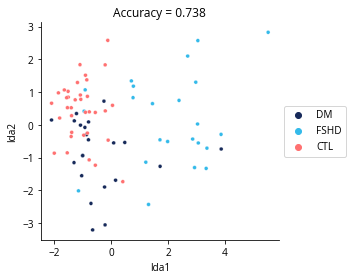

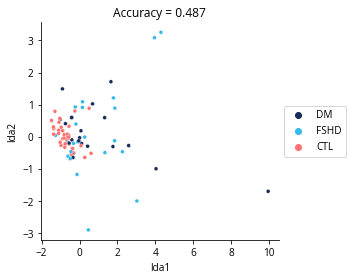

0.7375 0.4875 0.25000000000000006 0.512820512820513


In [143]:
feats = oc_feats
feats = ['brooke_max_min_sa',
         'mean_ea_at_max_mean_sa',
         'reachable_workspace',
         'run_speed',
         'jump_max_com_vel',
         'mean_int_aa']

all_feats = feats + tft_feats + ['brooke'] + ['activ_total']

df_include = df_all[['pid', 'type']+all_feats].dropna()

counts = df_include.groupby('type').count()['pid'].reset_index()
print("Included Data:")
print(counts.to_string(index=False, header = False))

df_out_oc, acc_oc = three_class_lda_cv(df_include, feats, 'type')
# _ = three_class_lda_cv(df_include, tfts_and_brooke, 'type')
df_out_tft, acc_tft = three_class_lda_cv(df_include, tft_feats, 'type')

print(acc_oc, acc_tft, acc_oc-acc_tft, (acc_oc - acc_tft) / acc_tft)


In [134]:
# rng = np.random.default_rng(0)

# N_sims = 1000 
# acc_ocs = []
# acc_tfts = []
# for k in trange(N_sims):
#     df_shuffle = df_include.copy()
#     df_shuffle.type = rng.permuted(df_shuffle.type.values)
#     df_shuffle

#     df_out_oc, acc_oc = three_class_lda_cv(df_shuffle, feats, 'type', show=False)
#     df_out_tft, acc_tft = three_class_lda_cv(df_shuffle, tft_feats, 'type', show=False)
    
#     acc_ocs.append(acc_oc)
#     acc_tfts.append(acc_tft)
    

  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# a_acc_ocs = np.array(acc_ocs)
# a_acc_tfts = np.array(acc_tfts)

# plt.hist(a_acc_ocs)
# plt.hist(acc_tfts)

# plt.hist(a_acc_ocs - a_acc_tfts)


In [128]:
rng = np.random.default_rng(0)

N_sims = 1000 
acc_ocs = []
acc_tfts = []
for k in trange(N_sims):

    N_samps = df_include.shape[0]
    df_resamp = df_include.sample(N_samps, replace=True).copy()
    df_resamp.pid = np.arange(N_samps)
    df_resamp

    df_out_oc, acc_oc = three_class_lda_cv(df_resamp, feats, 'type', show=False)
    df_out_tft, acc_tft = three_class_lda_cv(df_resamp, tft_feats, 'type', show=False)

    acc_ocs.append(acc_oc)
    acc_tfts.append(acc_tft)


  0%|          | 0/1000 [00:00<?, ?it/s]

(array([  3.,  19.,  42., 181., 251., 257., 187.,  43.,  16.,   1.]),
 array([-0.1125, -0.055 ,  0.0025,  0.06  ,  0.1175,  0.175 ,  0.2325,
         0.29  ,  0.3475,  0.405 ,  0.4625]),
 <BarContainer object of 10 artists>)

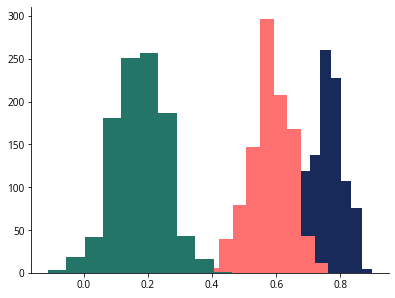

In [131]:
a_acc_ocs = np.array(acc_ocs)
a_acc_tfts = np.array(acc_tfts)

plt.hist(a_acc_ocs)
plt.hist(acc_tfts)

plt.hist(a_acc_ocs - a_acc_tfts)


In [ ]:
from sklearn import linear_model
from sklearn.metrics import 

